In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys, glob

In [3]:
import pandas as pd

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker

import matplotlib.dates as mdates

In [4]:
from datetime import datetime

### Required for google colab

In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# %cd /content/gdrive/My\ Drive/projects/covid2019-data-analysis/notebooks

In [6]:
# !gitIC_estimates.png
# 	modified:   IC_estimates_logscale.png
# 	modified:   confirmed_cases_prediction.png
# 	modified:   daily_data.png
# 	modified:   europe_aligned_dates.png
# 	modified:   europe_daily_increase_10days.png
# 	modified:   projections_covid2019_italy.ipynb

In [7]:
# !git status

In [8]:
# !git push --all

### Setup

In [9]:
DATA_DIR = "../csse_covid_19_data/csse_covid_19_daily_reports"

In [10]:
# sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="whitegrid")
# sns.set(font_scale = 2)
# sns.set_style("whitegrid", {'grid.linestyle': ':'})

## Data loading

In [11]:
csv_files = glob.glob(DATA_DIR + "/*.csv")

In [12]:
def extract_date(file_name):
    date_str = os.path.basename(file_name)[:-4]
#     print(date_str)
    
#     date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date = datetime.strptime(date_str, '%m-%d-%Y').date()
#     print(date)
    
    return date

In [13]:
world_df = None

for csv_file in csv_files:
    
    df = pd.read_csv(csv_file)
    date = extract_date(csv_file)
    df['Date'] = date
    
    if world_df is None:
        world_df = df
    else:
        world_df = pd.concat((world_df, df), ignore_index=True)
    
#     break

### Setup individual country

In [14]:
# Uncomment in case you want to check the list of countries with available data

# world_df['Country/Region'].unique()

In [15]:
country_name = "Italy"
ESTIMATED_IC_CAPACITY = 5000

# country_name = "Sweden"
# ESTIMATED_IC_CAPACITY = 1000

In [16]:
# Get data for a single country, sorted by date

country_df = world_df[world_df['Country/Region'] == country_name].sort_values(by='Date')

# Estimate a reasonable value for Y tick given the maximum number of cases
Y_GRID_TICK = 10**int(np.log10(country_df['Confirmed'].max()))/2

In [17]:
# Uncomment to check data for a specific day

country_df[country_df['Date'] == datetime.strptime("03-03-2020", '%m-%d-%Y').date()]

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
5656,NaN,Italy,2020-03-03T20:03:06,2502.0,79.0,160.0,2020-03-03,43.0,12.0


In [18]:
# Check latest data

country_df.tail()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,Latitude,Longitude
2436,NaN,Italy,2020-03-11T20:00:00,17660.0,1266.0,1439.0,2020-03-13,41.8719,12.5674
5406,NaN,Italy,2020-03-14T20:13:16,21157.0,1441.0,1966.0,2020-03-14,41.8719,12.5674
4565,NaN,Italy,2020-03-14T20:13:16,24747.0,1809.0,2335.0,2020-03-15,41.8719,12.5674
1254,NaN,Italy,2020-03-16T17:33:03,27980.0,2158.0,2749.0,2020-03-16,41.8719,12.5674
2029,NaN,Italy,2020-03-17T18:33:02,31506.0,2503.0,2941.0,2020-03-17,41.8719,12.5674


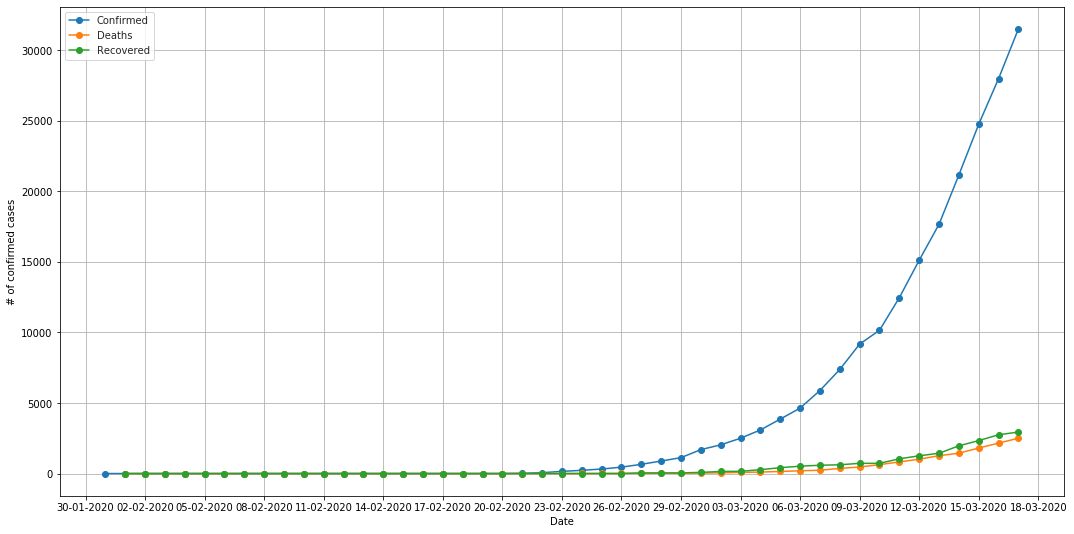

In [19]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

country_df.plot(x='Date', y=["Confirmed", "Deaths"], figsize=(20,10), ax=ax, marker='o')
country_df.plot(x='Date', y=["Recovered"], figsize=(18,9), ax=ax, marker='o')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylabel("# of confirmed cases");

plt.savefig("daily_data.png");

$y = e^{ax}$

$\ln{y} = ax$

## ML analysis

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# Set range of data to build model

# It might make sense to skip part of the initial points, when the exponential trend was still not evident
RANGE_START = 0
RANGE_END = None

In [44]:
# y = np.log(country_df[country_df['Date'] > '2020-02-23']['Confirmed'])
y = np.log(country_df['Confirmed'])

# y = np.log(country_df[country_df['Date'] > datetime(2020, 2, 23).date()]['Confirmed'])
x = np.arange(len(y))

In [45]:
country_df[country_df['Date'] > datetime(2020, 2, 23).date()]['Confirmed']

3907      229.0
4838      322.0
3991      453.0
5815      655.0
84        888.0
3298     1128.0
2971     1694.0
6299     2036.0
5656     2502.0
3414     3089.0
6126     3858.0
3097     4636.0
1805     5883.0
4154     7375.0
242      9172.0
3573    10149.0
707     12462.0
2605    15113.0
2436    17660.0
5406    21157.0
4565    24747.0
1254    27980.0
2029    31506.0
Name: Confirmed, dtype: float64

In [46]:
reg = LinearRegression()
reg.fit(x[RANGE_START:RANGE_END][:,np.newaxis], y[RANGE_START:RANGE_END])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Create dataframe with estimates

In [47]:
estimate_dates = pd.date_range(start='1/31/2020', end='03/18/2020')
estimate_cases = np.exp(reg.predict(np.arange(len(estimate_dates))[:, np.newaxis]))

In [48]:
df_estimates = pd.DataFrame({"Date": estimate_dates, "Predictions": estimate_cases})

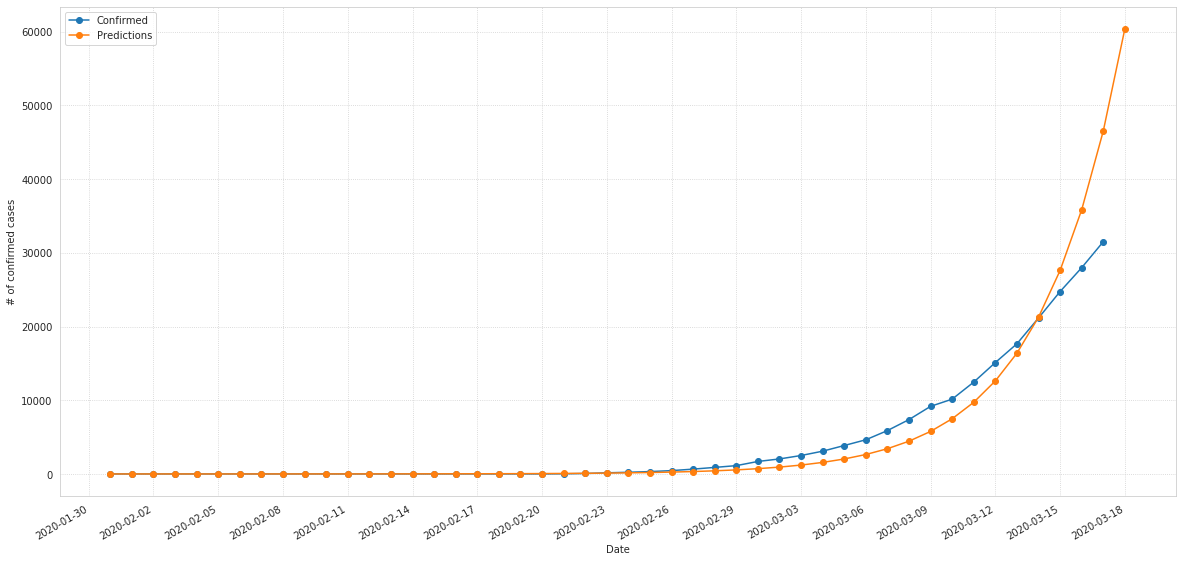

In [49]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions"], figsize=(20,10), ax=ax, marker='o')


# ax.yaxis.set_major_locator(ticker.MultipleLocator(Y_GRID_TICK))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of confirmed cases");

plt.savefig("confirmed_cases_prediction.png");

# Use lines below in case you want to highlight a specific date/value

# ax.axhline(9172, 0, 1, ls=':', color='red')
# ax.axvline("2020-03-09", 0, 1, ls=':', color='red')

### Estimate people in IC

Assume that 10% of infected people require a bed in IC

In [27]:
country_df['Confirmed_IC'] = country_df['Confirmed']*0.1
df_estimates['Predictions_IC'] = df_estimates['Predictions']*0.1
df_estimates['IC caspacity (national)'] = ESTIMATED_IC_CAPACITY

### Plot results

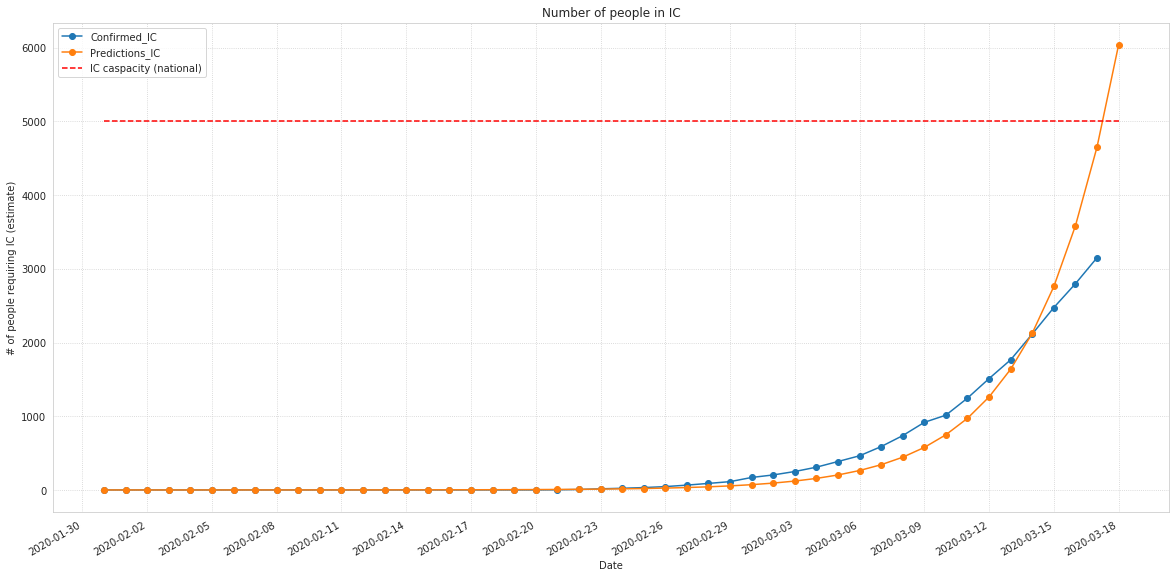

In [28]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--')
plt.title("Number of people in IC");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

plt.savefig("IC_estimates.png");

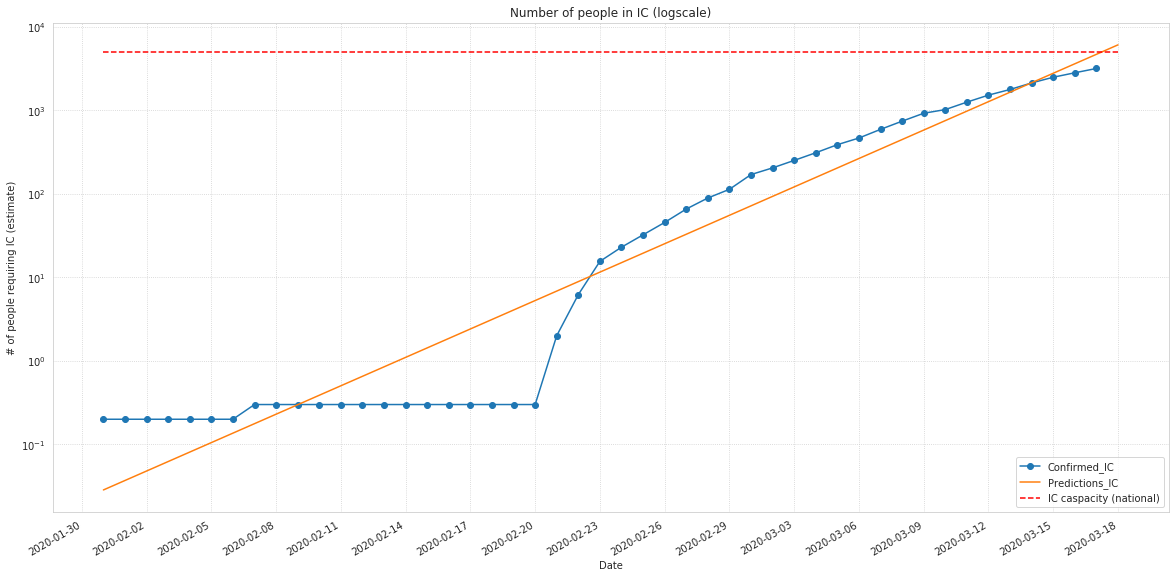

In [29]:
ax = plt.gca()

country_df.plot(x='Date', y=["Confirmed_IC"], figsize=(20,10), ax=ax, marker='o')
df_estimates.plot(x='Date', y=["Predictions_IC"], figsize=(20,10), ax=ax)
df_estimates.plot(x='Date', y=['IC caspacity (national)'], ax=ax, color='red', ls='--', logy=True)
plt.title("Number of people in IC (logscale)");

sns.set_style("whitegrid", {'grid.linestyle': ':'})

# ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax.set_ylabel("# of people requiring IC (estimate)");

plt.savefig("IC_estimates_logscale.png");

## Countries comparison

Dates for Italy, Norway and Sweden have been manually aligned so that trends overlap.

In addition to that, data from Italy is truncated (data from the last 9 days is omitted) so that it doesn't make lines from other countries difficult to see.

In [30]:
def get_country_df(world_df, country_name):
    
    # Some countries have several Provinces/States, must aggregate
    country_df = world_df[world_df['Country/Region'] == country_name] \
        .groupby(["Country/Region", "Date"]) \
        .sum() \
        .sort_values(by='Date')
    
    # Restore columns
    country_df['Country/Region'] = [i[0] for i in country_df.index]
    country_df['Date'] = [i[1] for i in country_df.index]
    
    return country_df
#     return world_df[world_df['Province/State'] == country_name].sort_values(by='Date')

In [31]:

spain_df = get_country_df(world_df, "Spain")

# spain_df['Date'][-37:]

# spain_df[spain_df['Date'] >= '2020-02-09']['Date']
spain_df[spain_df['Date'] >= datetime(2020, 2, 9).date()]['Date']




# get_country_df(world_df, "Spain")['Date'][-37:]

Country/Region  Date      
Spain           2020-02-09    2020-02-09
                2020-02-10    2020-02-10
                2020-02-11    2020-02-11
                2020-02-12    2020-02-12
                2020-02-13    2020-02-13
                2020-02-14    2020-02-14
                2020-02-15    2020-02-15
                2020-02-16    2020-02-16
                2020-02-17    2020-02-17
                2020-02-18    2020-02-18
                2020-02-19    2020-02-19
                2020-02-20    2020-02-20
                2020-02-21    2020-02-21
                2020-02-22    2020-02-22
                2020-02-23    2020-02-23
                2020-02-24    2020-02-24
                2020-02-25    2020-02-25
                2020-02-26    2020-02-26
                2020-02-27    2020-02-27
                2020-02-28    2020-02-28
                2020-02-29    2020-02-29
                2020-03-01    2020-03-01
                2020-03-02    2020-03-02
                2020-03-03    

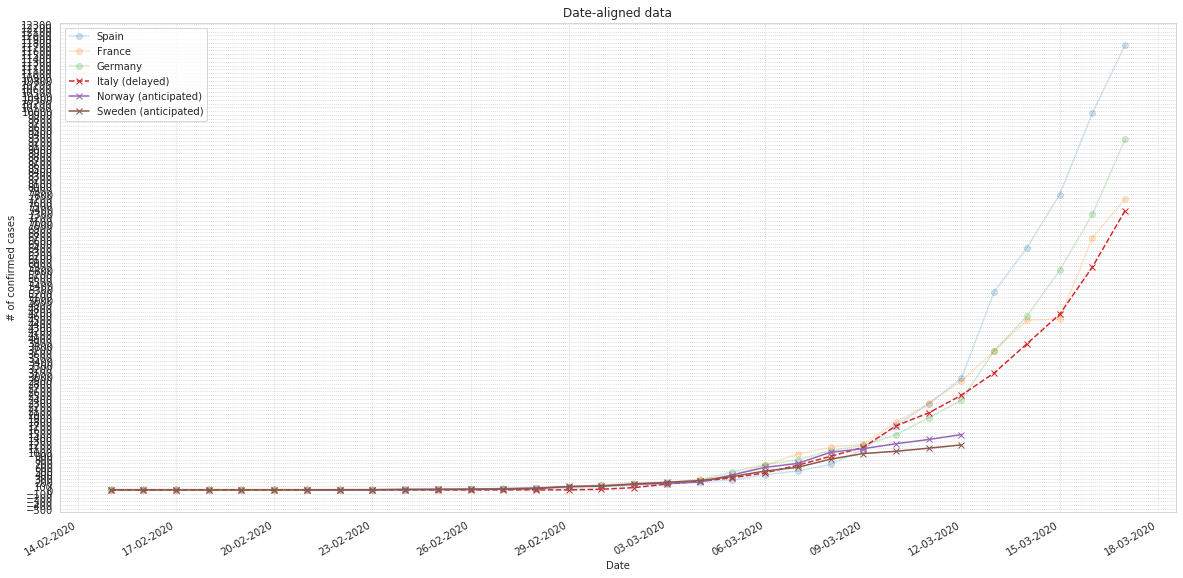

In [32]:
from datetime import timedelta

ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


countries_to_plot = [
#     "Italy",
    "Spain",
    "France",
    "Germany",
#     "Norway",
#     "Sweden",
]

for cc in countries_to_plot:
    c_df = get_country_df(world_df, cc)
    c_df = c_df[c_df['Date'] > datetime(2020, 2,14).date()]
    
    c_df.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='o', alpha=0.2)
    pass

italy_delayed = get_country_df(world_df, "Italy")
italy_delayed = italy_delayed.iloc[:-9,:]

spain_df = get_country_df(world_df, "Spain")
italy_delayed['Date'] = list(spain_df[spain_df['Date'] >= datetime(2020, 2, 9).date()]['Date'])

# Update date dynamically
end_date_skandinavia = (datetime.today() - timedelta(days=6)).date().strftime("%m-%d-%Y")

norway_anticipated = get_country_df(world_df, "Norway")
norway_anticipated['Date'] = pd.date_range(end=end_date_skandinavia, periods=len(norway_anticipated))

sweden_anticipated = get_country_df(world_df, "Sweden")
sweden_anticipated['Date'] = pd.date_range(end=end_date_skandinavia, periods=len(sweden_anticipated))

# Plot adjusted countries
italy_delayed = italy_delayed[italy_delayed['Date'] > datetime(2020, 2,14).date()]
italy_delayed.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x', ls="--")

norway_anticipated = norway_anticipated[norway_anticipated['Date'] > "2020-02-14"]
sweden_anticipated = sweden_anticipated[sweden_anticipated['Date'] > "2020-02-14"]

norway_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')
sweden_anticipated.plot(x='Date', y=["Confirmed"], figsize=(20,10), ax=ax, marker='x')

ax.legend(countries_to_plot + ['Italy (delayed)', 'Norway (anticipated)', 'Sweden (anticipated)'])
ax.set_ylabel("# of confirmed cases")

plt.title("Date-aligned data");

plt.savefig("europe_aligned_dates.png");

In [33]:
get_country_df(world_df, "Spain").tail()

Confirmed  Deaths  Recovered  Latitude  Longitude  \
Country/Region Date                                                            
Spain          2020-03-13     5232.0   133.0      193.0   40.4637    -3.7492   
               2020-03-14     6391.0   195.0      517.0   40.4637    -3.7492   
               2020-03-15     7798.0   289.0      517.0   40.4637    -3.7492   
               2020-03-16     9942.0   342.0      530.0   40.4637    -3.7492   
               2020-03-17    11748.0   533.0     1028.0   40.4637    -3.7492   

                          Country/Region        Date  
Country/Region Date                                   
Spain          2020-03-13          Spain  2020-03-13  
               2020-03-14          Spain  2020-03-14  
               2020-03-15          Spain  2020-03-15  
               2020-03-16          Spain  2020-03-16  
               2020-03-17          Spain  2020-03-17

In [34]:
get_country_df(world_df, "Spain")['Confirmed'][-1]

11748.0

In [35]:

daily_increase_df = pd.DataFrame(columns=['Country', 'Date', 'Increase'])

N_data_points = 10

countries = [
    'Spain', 
    'France', 
    'Germany', 
    'Italy', 
    'Norway', 
    'Sweden',
]

for c in countries:

    c_df = get_country_df(world_df, c)

    for i in range(N_data_points):
        inc = c_df['Confirmed'][-N_data_points+i]/c_df['Confirmed'][-N_data_points+i-1]

        daily_increase_df_row = pd.DataFrame.from_dict({'Country': [c], 'Date': [c_df['Date'][-N_data_points+i]], 'Increase': [inc]})

        daily_increase_df = pd.concat((daily_increase_df, daily_increase_df_row), ignore_index=True)
        
daily_increase_df['Increase_p'] = (daily_increase_df['Increase'] - 1) * 100

/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f29905e90> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f2991bc10> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f2993c190> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f6f298dcb50> has a label of '_' which cannot be automatically added to the legend.
/home/matteo/miniconda3/envs/jupyter/lib/python3.7/site-

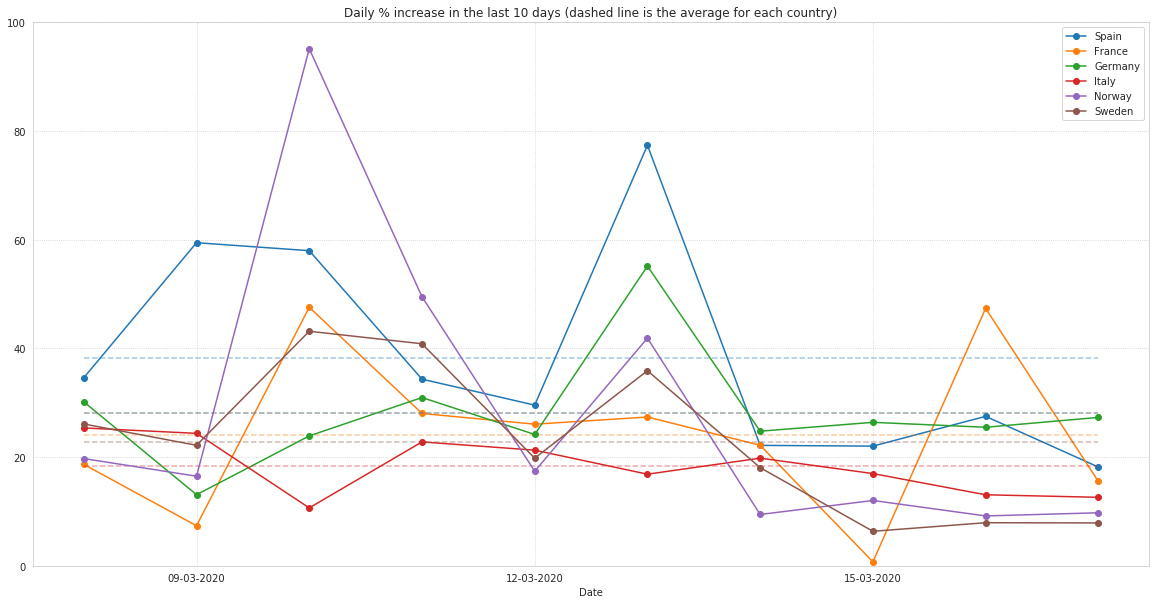

In [36]:
ax = plt.gca()

sns.set_style("whitegrid", {'grid.linestyle': ':'})
# ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


legend_strings = list()


for c in countries:
    
    daily_increase_df_country = daily_increase_df[daily_increase_df['Country'] == c].copy()
    
    daily_increase_df_country['Average'] = daily_increase_df_country['Increase'].mean()
    daily_increase_df_country['Average_p'] = daily_increase_df_country['Increase_p'].mean()
    
    # Plot daily increase
    daily_increase_df_country.plot(x='Date', y=["Increase_p"], figsize=(20,10), ax=ax, marker='o')
    
#     ax.lines[-1].set_label(c)
    
    # Plot mean (no label)
    
    daily_increase_df_country.plot(
        x='Date', y=["Average_p"], 
        figsize=(20,10), ax=ax, ls="--", alpha=0.4, color=ax.lines[-1].get_color(), legend=False)
    
#     print(dir(ax.lines[-1]))
    
#     ax.lines[-1].set_label("_")
    
#     legend_strings.extend([c, f"{c} (average)"])
    legend_strings.extend([c, "_"])
    
ax.legend(legend_strings)
# ax.legend(countries)

# Limit y range to increase visibility
# ax.set_ylim(1, 2.2);
ax.set_ylim(0, 100);

ax.set_title("Daily % increase in the last 10 days (dashed line is the average for each country)");
plt.savefig("europe_daily_increase_10days.png");
